In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumour-mri-scans/data/images/2664.png
/kaggle/input/brain-tumour-mri-scans/data/images/2539.png
/kaggle/input/brain-tumour-mri-scans/data/images/1231.png
/kaggle/input/brain-tumour-mri-scans/data/images/1017.png
/kaggle/input/brain-tumour-mri-scans/data/images/2437.png
/kaggle/input/brain-tumour-mri-scans/data/images/2015.png
/kaggle/input/brain-tumour-mri-scans/data/images/2300.png
/kaggle/input/brain-tumour-mri-scans/data/images/2673.png
/kaggle/input/brain-tumour-mri-scans/data/images/2823.png
/kaggle/input/brain-tumour-mri-scans/data/images/1522.png
/kaggle/input/brain-tumour-mri-scans/data/images/2064.png
/kaggle/input/brain-tumour-mri-scans/data/images/641.png
/kaggle/input/brain-tumour-mri-scans/data/images/1088.png
/kaggle/input/brain-tumour-mri-scans/data/images/173.png
/kaggle/input/brain-tumour-mri-scans/data/images/2851.png
/kaggle/input/brain-tumour-mri-scans/data/images/2448.png
/kaggle/input/brain-tumour-mri-scans/data/images/1746.png
/kaggle/input/br

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dbconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.dbconv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.inconv = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256) 
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        x1 = self.inconv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        return x

In [3]:
from PIL import Image
from torch.utils.data import Dataset

class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

        assert len(self.image_paths) == len(self.mask_paths)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert("L")
        mask = Image.open(self.mask_paths[index]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, omega1=1.0, omega2=1.0, epsilon=1e-6):

        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.omega1 = omega1
        self.omega2 = omega2
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = preds.contiguous().view(preds.size(0), -1)
        targets = targets.contiguous().view(targets.size(0), -1)

        preds_sigmoid = torch.sigmoid(preds)
        pt = preds_sigmoid * targets + (1 - preds_sigmoid) * (1 - targets) 
        focal_loss = -self.alpha * (1 - pt).pow(self.gamma) * torch.log(pt + self.epsilon)
        focal_loss = focal_loss.mean()

        intersection = (preds_sigmoid * targets).sum(dim=1)
        union = preds_sigmoid.sum(dim=1) + targets.sum(dim=1)
        dice = (2.0 * intersection + self.epsilon) / (union + self.epsilon)
        dice_loss = 1.0 - dice.mean()

        log_cosh_dice_loss = torch.log(torch.cosh(dice_loss))

        combined_loss = self.omega1 * focal_loss + self.omega2 * (dice_loss**self.gamma) * log_cosh_dice_loss
        return combined_loss

In [ ]:
from torchvision import transforms
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from PIL import Image
import numpy as np
import os

def data_loaders(root_dir, train_test_ratio=0.8, train_val_ratio=0.25, target_size=(512, 512), batch_size=16, random_state=42):

    image_dir = Path(root_dir) / "images"
    mask_dir = Path(root_dir) / "masks"

    image_paths = list(image_dir.glob("*.png"))
    mask_paths = list(mask_dir.glob("*.png"))

    train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
        image_paths, mask_paths, train_size=train_test_ratio, random_state=random_state
    )
    
    train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
        train_image_paths, train_mask_paths, train_size=train_val_ratio, random_state=random_state
    )

    data_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])

    train_dataset = BrainTumorSegmentationDataset(
        train_image_paths, 
        train_mask_paths,
        transform=data_transform,
    )
    val_dataset = BrainTumorSegmentationDataset(
        val_image_paths, 
        val_mask_paths,
        transform=data_transform,
    )

    test_dataset = BrainTumorSegmentationDataset(
        test_image_paths, 
        test_mask_paths,
        transform=data_transform,
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
import torch
from tqdm import tqdm
import gc  

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device, resize_transform=None, early_stopping_patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') 
    patience_counter = 0 

    scaler = torch.amp.GradScaler("cuda")

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0

        for img, mask in tqdm(train_loader, desc="Training", leave=True, mininterval=2.0):
            if resize_transform:
                img = resize_transform(img)
                mask = resize_transform(mask)

            img, mask = img.to(device), mask.to(device)

            optimizer.zero_grad()  

            with torch.cuda.amp.autocast():
                y_pred = model(img)
                loss = loss_fn(y_pred, mask)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for idx, (img, mask) in enumerate(tqdm(val_loader, desc="Validation", leave=True, mininterval=2.0)):
                if resize_transform:
                    img = resize_transform(img)
                    mask = resize_transform(mask)

                img, mask = img.to(device), mask.to(device)

                y_pred = model(img)
                loss = loss_fn(y_pred, mask)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }
            torch.save(checkpoint, "best_model_checkpoint.pth")
            print(f"New best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in val_loss for {patience_counter} epoch(s).")

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

        torch.cuda.empty_cache()  
        gc.collect()  

        print("-" * 30)
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}")
        print(f"Epoch: {epoch + 1}, Val Loss: {val_loss:.4f}")
        print("-" * 30)

    return train_losses, val_losses

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
root_dir = "/kaggle/input/brain-tumour-mri-scans/data/"
train_loader, val_loader, test_loader = data_loaders(root_dir=root_dir, batch_size=4)

In [9]:
import torch.optim as optim

model = UNet(in_channels=1, out_channels=1).to(device)
n_epochs = 100
lr = 1e-4
loss_fn = FocalDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
from torchvision import transforms

train_losses, val_losses = training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    resize_transform=transforms.Resize((512, 512))
)

Training:   0%|          | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_536/2709167097.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 460/460 [01:07<00:00,  6.78it/s]


New best model saved at epoch 1 with val_loss: 0.3002
------------------------------
Epoch: 1, Train Loss: 0.3389
Epoch: 1, Val Loss: 0.3002
------------------------------


Validation: 100%|██████████| 460/460 [01:06<00:00,  6.90it/s]


New best model saved at epoch 2 with val_loss: 0.2580
------------------------------
Epoch: 2, Train Loss: 0.2739
Epoch: 2, Val Loss: 0.2580
------------------------------


Validation: 100%|██████████| 460/460 [01:06<00:00,  6.92it/s]


New best model saved at epoch 3 with val_loss: 0.2197
------------------------------
Epoch: 3, Train Loss: 0.2227
Epoch: 3, Val Loss: 0.2197
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


New best model saved at epoch 4 with val_loss: 0.1500
------------------------------
Epoch: 4, Train Loss: 0.1713
Epoch: 4, Val Loss: 0.1500
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.00it/s]


New best model saved at epoch 5 with val_loss: 0.1405
------------------------------
Epoch: 5, Train Loss: 0.1305
Epoch: 5, Val Loss: 0.1405
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  6.99it/s]


New best model saved at epoch 6 with val_loss: 0.0897
------------------------------
Epoch: 6, Train Loss: 0.1000
Epoch: 6, Val Loss: 0.0897
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.03it/s]


New best model saved at epoch 7 with val_loss: 0.0763
------------------------------
Epoch: 7, Train Loss: 0.0748
Epoch: 7, Val Loss: 0.0763
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.01it/s]


New best model saved at epoch 8 with val_loss: 0.0655
------------------------------
Epoch: 8, Train Loss: 0.0588
Epoch: 8, Val Loss: 0.0655
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.00it/s]


New best model saved at epoch 9 with val_loss: 0.0421
------------------------------
Epoch: 9, Train Loss: 0.0436
Epoch: 9, Val Loss: 0.0421
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  6.98it/s]


No improvement in val_loss for 1 epoch(s).
------------------------------
Epoch: 10, Train Loss: 0.0353
Epoch: 10, Val Loss: 0.0516
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


No improvement in val_loss for 2 epoch(s).
------------------------------
Epoch: 11, Train Loss: 0.0333
Epoch: 11, Val Loss: 0.0507
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.03it/s]


New best model saved at epoch 12 with val_loss: 0.0336
------------------------------
Epoch: 12, Train Loss: 0.0288
Epoch: 12, Val Loss: 0.0336
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.01it/s]


No improvement in val_loss for 1 epoch(s).
------------------------------
Epoch: 13, Train Loss: 0.0288
Epoch: 13, Val Loss: 0.0422
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


No improvement in val_loss for 2 epoch(s).
------------------------------
Epoch: 14, Train Loss: 0.0433
Epoch: 14, Val Loss: 0.0572
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


New best model saved at epoch 15 with val_loss: 0.0312
------------------------------
Epoch: 15, Train Loss: 0.0269
Epoch: 15, Val Loss: 0.0312
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  6.99it/s]


New best model saved at epoch 16 with val_loss: 0.0242
------------------------------
Epoch: 16, Train Loss: 0.0155
Epoch: 16, Val Loss: 0.0242
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  6.99it/s]


No improvement in val_loss for 1 epoch(s).
------------------------------
Epoch: 17, Train Loss: 0.0140
Epoch: 17, Val Loss: 0.0275
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


No improvement in val_loss for 2 epoch(s).
------------------------------
Epoch: 18, Train Loss: 0.0158
Epoch: 18, Val Loss: 0.0269
------------------------------


Validation: 100%|██████████| 460/460 [01:06<00:00,  6.95it/s]


No improvement in val_loss for 3 epoch(s).
------------------------------
Epoch: 19, Train Loss: 0.0280
Epoch: 19, Val Loss: 0.0317
------------------------------


Validation: 100%|██████████| 460/460 [01:06<00:00,  6.94it/s]


No improvement in val_loss for 4 epoch(s).
------------------------------
Epoch: 20, Train Loss: 0.0140
Epoch: 20, Val Loss: 0.0304
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


No improvement in val_loss for 5 epoch(s).
------------------------------
Epoch: 21, Train Loss: 0.0119
Epoch: 21, Val Loss: 0.0306
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.05it/s]


No improvement in val_loss for 6 epoch(s).
------------------------------
Epoch: 22, Train Loss: 0.0094
Epoch: 22, Val Loss: 0.0287
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.06it/s]


No improvement in val_loss for 7 epoch(s).
------------------------------
Epoch: 23, Train Loss: 0.0097
Epoch: 23, Val Loss: 0.0315
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


New best model saved at epoch 24 with val_loss: 0.0228
------------------------------
Epoch: 24, Train Loss: 0.0086
Epoch: 24, Val Loss: 0.0228
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.03it/s]


No improvement in val_loss for 1 epoch(s).
------------------------------
Epoch: 25, Train Loss: 0.0093
Epoch: 25, Val Loss: 0.0239
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.05it/s]


No improvement in val_loss for 2 epoch(s).
------------------------------
Epoch: 26, Train Loss: 0.0216
Epoch: 26, Val Loss: 0.0385
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.03it/s]


No improvement in val_loss for 3 epoch(s).
------------------------------
Epoch: 27, Train Loss: 0.0108
Epoch: 27, Val Loss: 0.0261
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.05it/s]


New best model saved at epoch 28 with val_loss: 0.0220
------------------------------
Epoch: 28, Train Loss: 0.0086
Epoch: 28, Val Loss: 0.0220
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


No improvement in val_loss for 1 epoch(s).
------------------------------
Epoch: 29, Train Loss: 0.0064
Epoch: 29, Val Loss: 0.0286
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.04it/s]


No improvement in val_loss for 2 epoch(s).
------------------------------
Epoch: 30, Train Loss: 0.0059
Epoch: 30, Val Loss: 0.0298
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.02it/s]


New best model saved at epoch 31 with val_loss: 0.0185
------------------------------
Epoch: 31, Train Loss: 0.0046
Epoch: 31, Val Loss: 0.0185
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  6.98it/s]


No improvement in val_loss for 1 epoch(s).
------------------------------
Epoch: 32, Train Loss: 0.0053
Epoch: 32, Val Loss: 0.0791
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.04it/s]


No improvement in val_loss for 2 epoch(s).
------------------------------
Epoch: 33, Train Loss: 0.0287
Epoch: 33, Val Loss: 0.0287
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.05it/s]


No improvement in val_loss for 3 epoch(s).
------------------------------
Epoch: 34, Train Loss: 0.0112
Epoch: 34, Val Loss: 0.0263
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.06it/s]


No improvement in val_loss for 4 epoch(s).
------------------------------
Epoch: 35, Train Loss: 0.0065
Epoch: 35, Val Loss: 0.0244
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.05it/s]


No improvement in val_loss for 5 epoch(s).
------------------------------
Epoch: 36, Train Loss: 0.0056
Epoch: 36, Val Loss: 0.0217
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.04it/s]


No improvement in val_loss for 6 epoch(s).
------------------------------
Epoch: 37, Train Loss: 0.0041
Epoch: 37, Val Loss: 0.0216
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.04it/s]


No improvement in val_loss for 7 epoch(s).
------------------------------
Epoch: 38, Train Loss: 0.0034
Epoch: 38, Val Loss: 0.0236
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.05it/s]


No improvement in val_loss for 8 epoch(s).
------------------------------
Epoch: 39, Train Loss: 0.0038
Epoch: 39, Val Loss: 0.0294
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.03it/s]


No improvement in val_loss for 9 epoch(s).
------------------------------
Epoch: 40, Train Loss: 0.0032
Epoch: 40, Val Loss: 0.0199
------------------------------


Validation: 100%|██████████| 460/460 [01:05<00:00,  7.00it/s]

No improvement in val_loss for 10 epoch(s).
Early stopping triggered at epoch 41.


In [34]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=1, out_channels=1).to(device)
checkpoint = torch.load("best_model_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch = checkpoint["epoch"]
val_loss = checkpoint["val_loss"]

print(f"Restored model trained up to epoch {epoch} with best val_loss: {val_loss:.4f}")

Restored model trained up to epoch 31 with best val_loss: 0.0185


/tmp/ipykernel_536/3789936447.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_checkpoint.pth", map_location=device)


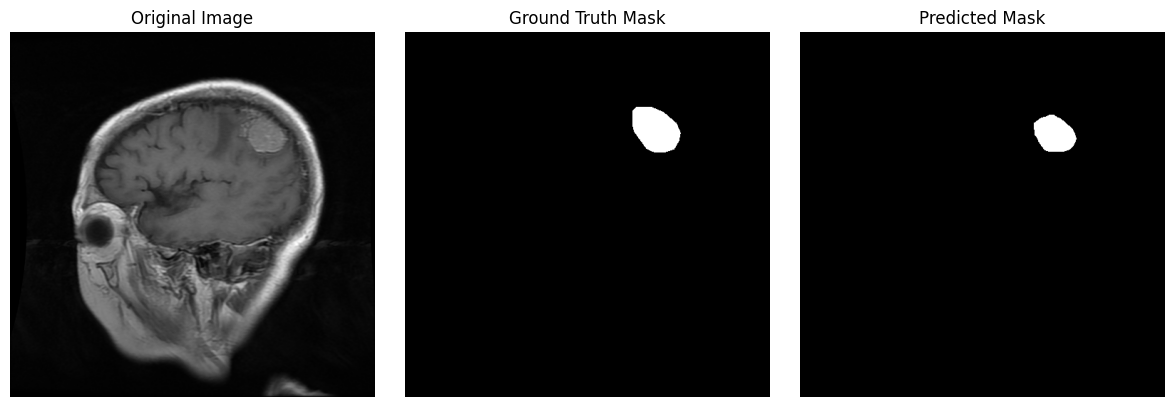

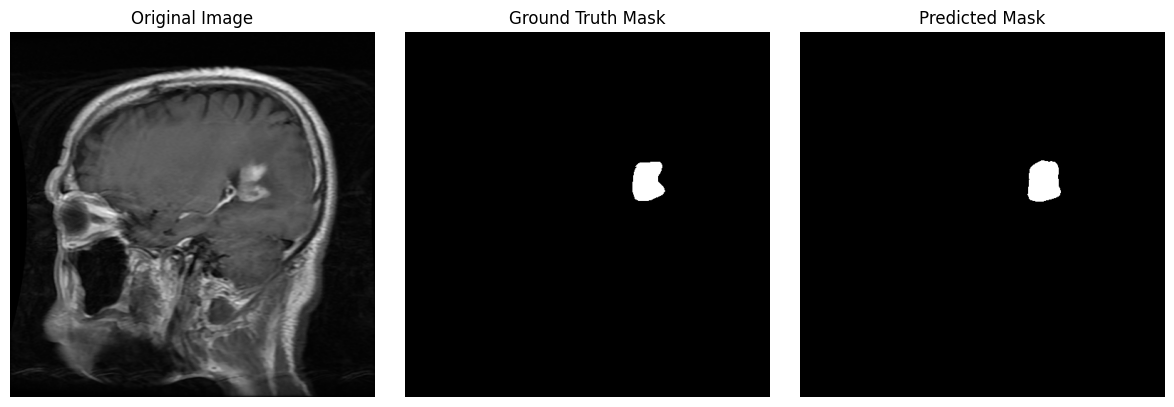

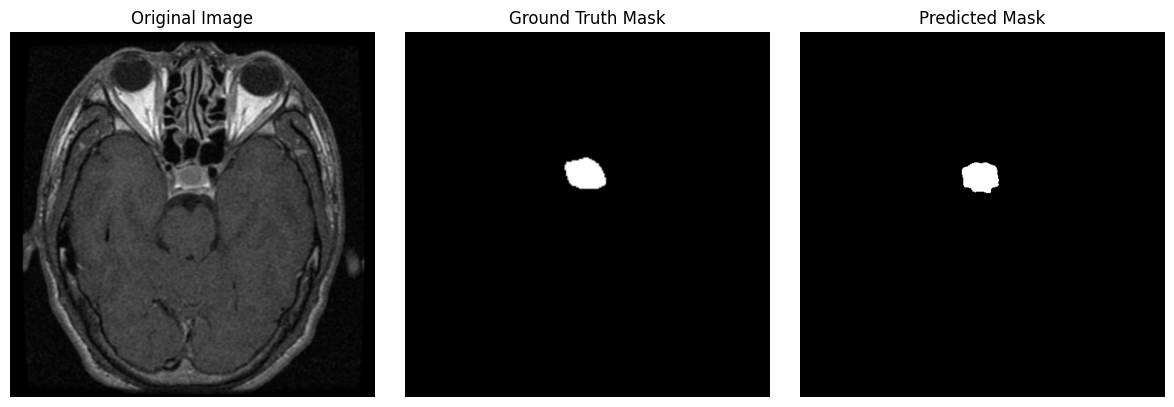

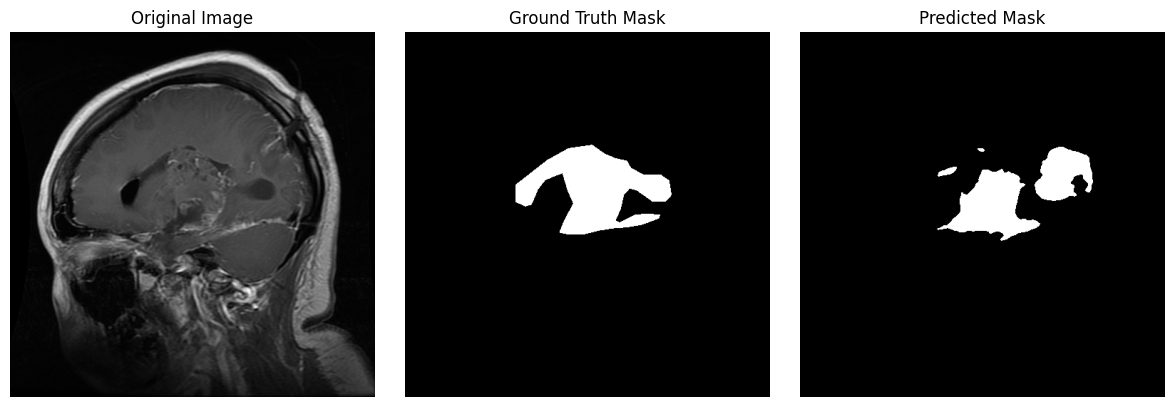

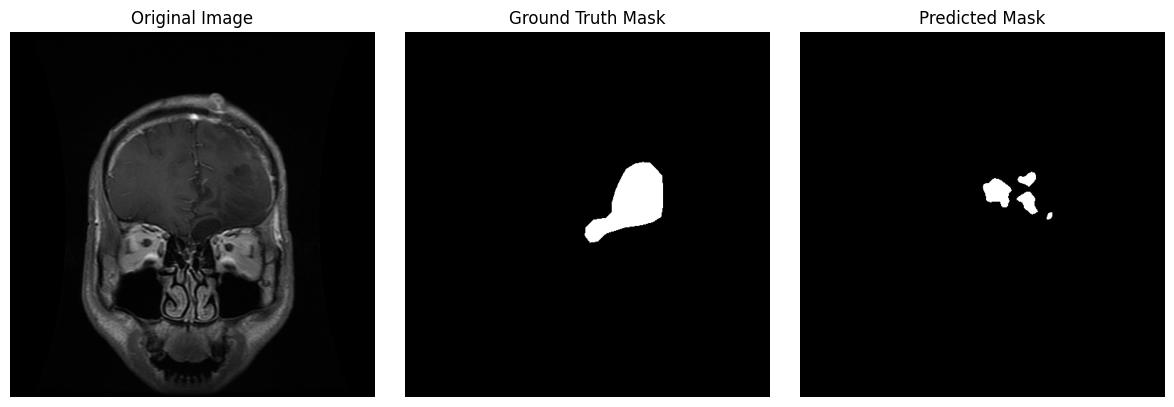

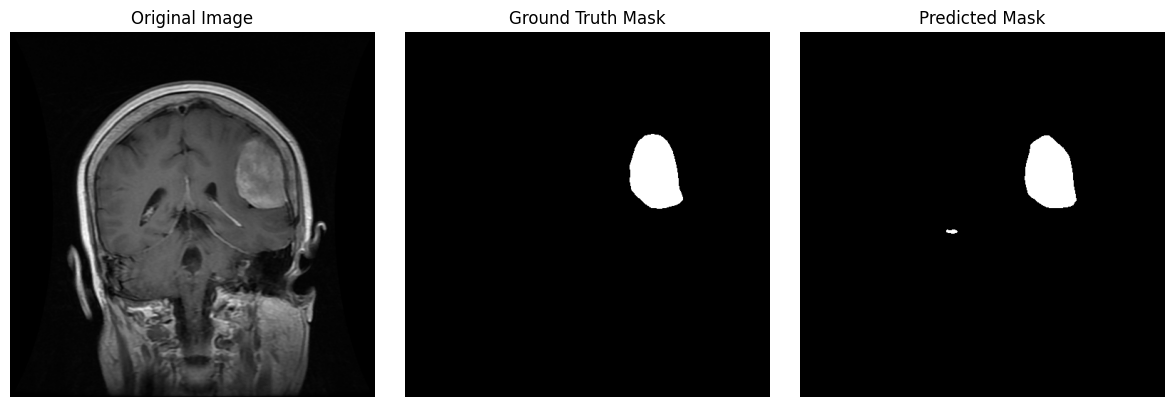

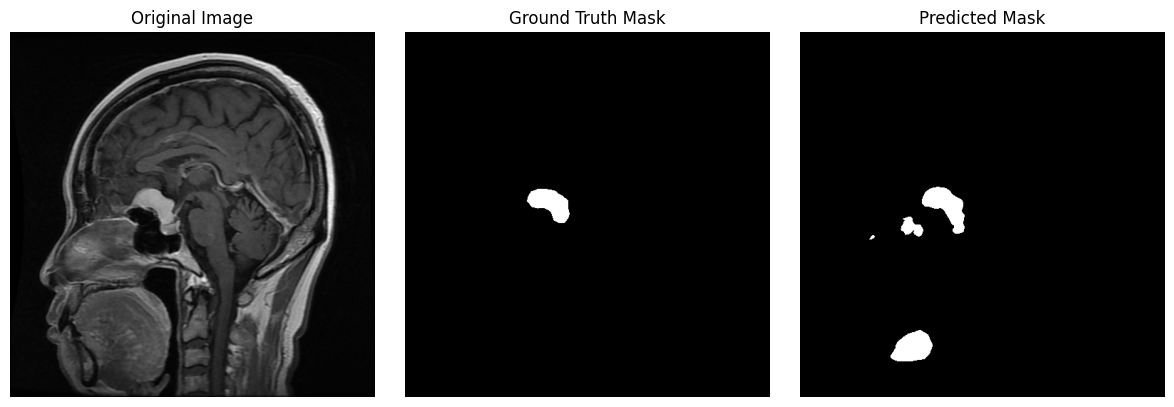

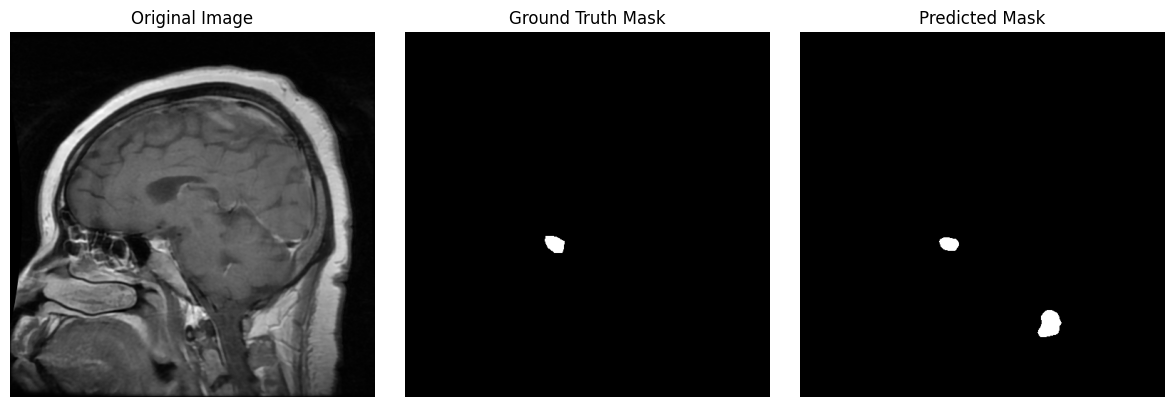

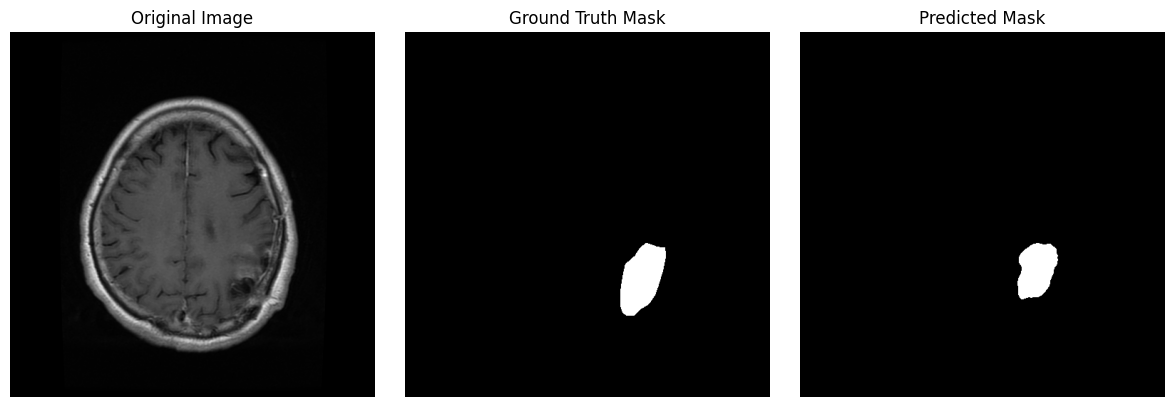

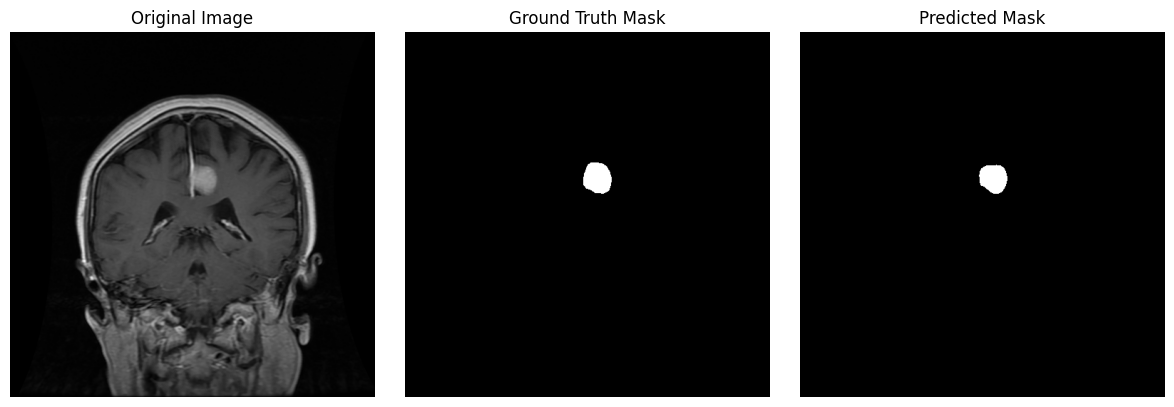

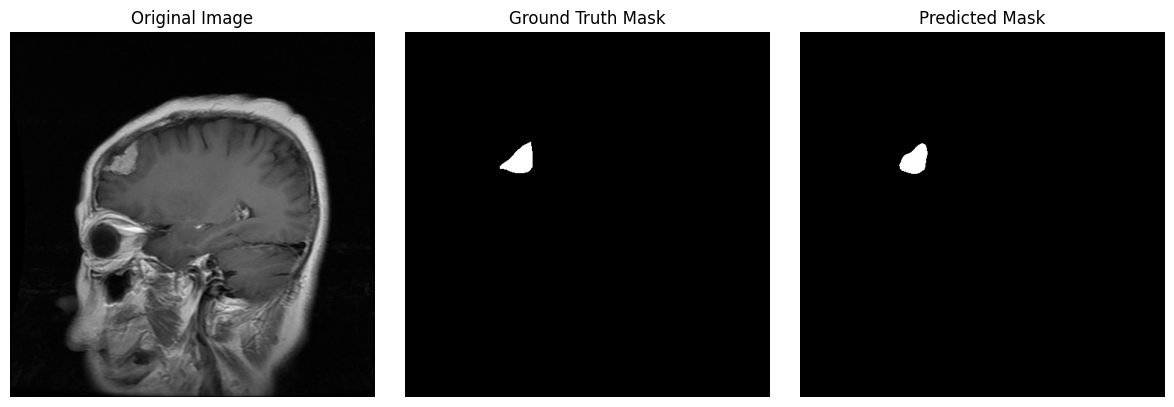

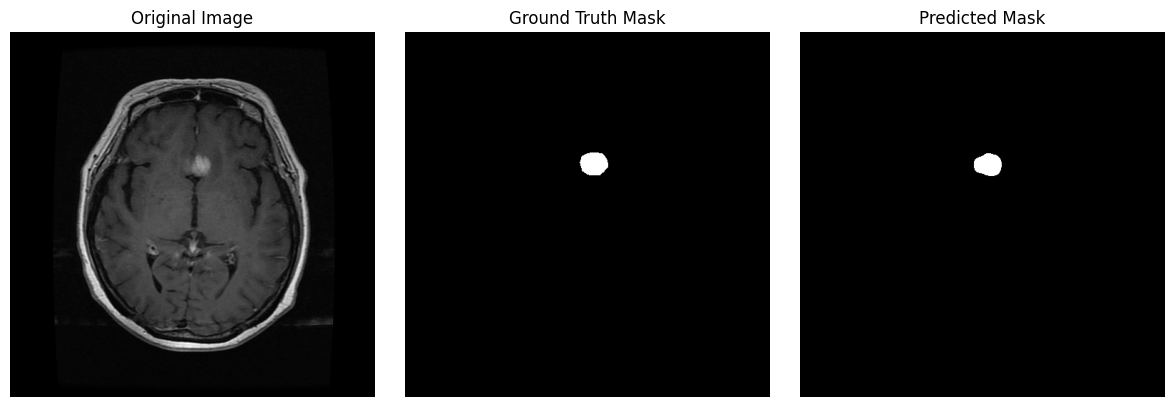

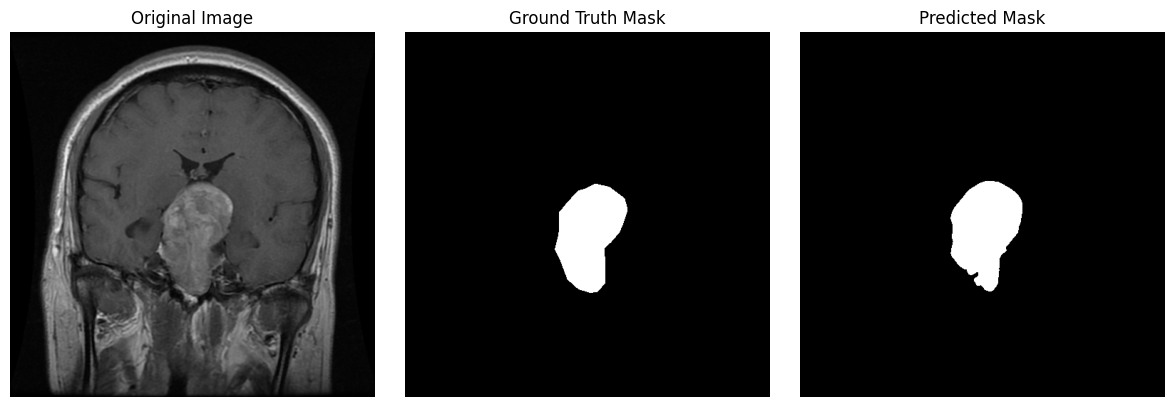

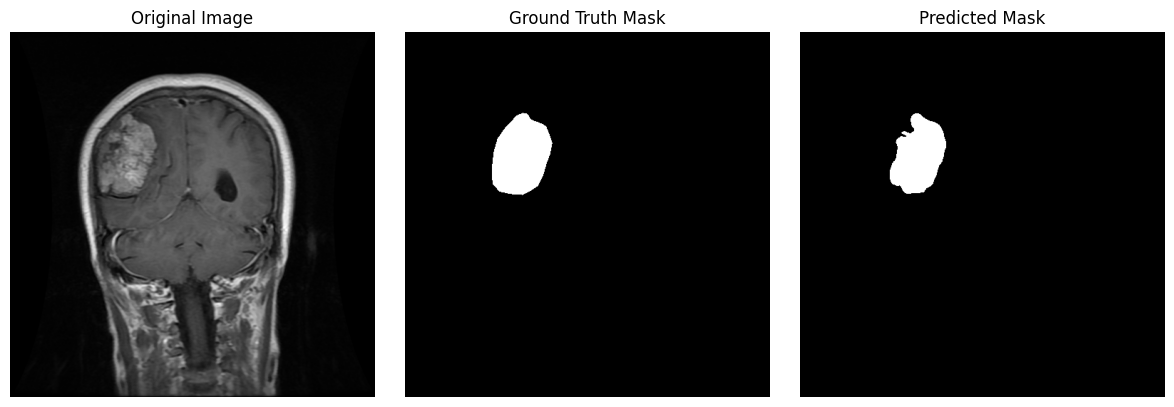

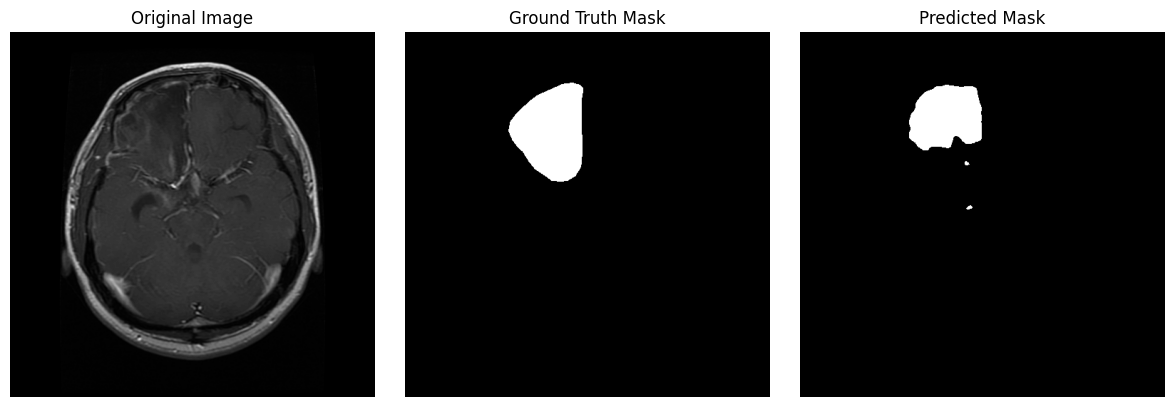

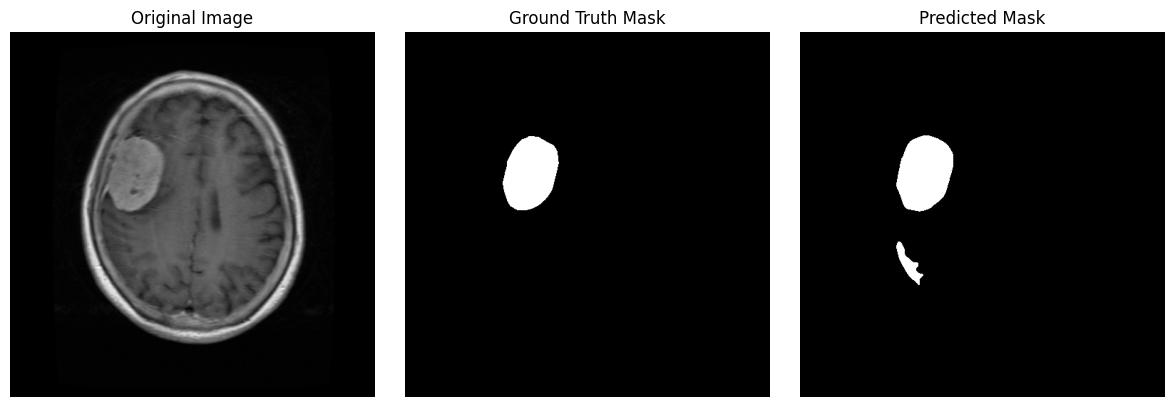

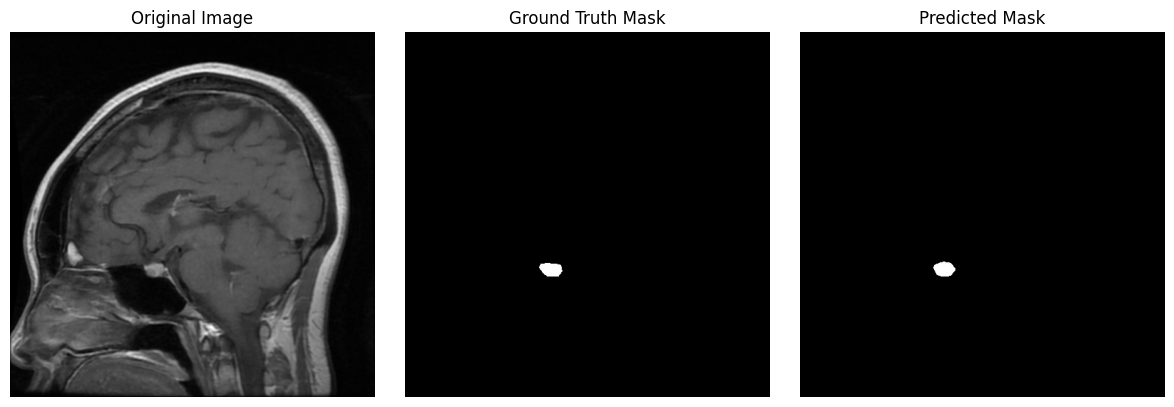

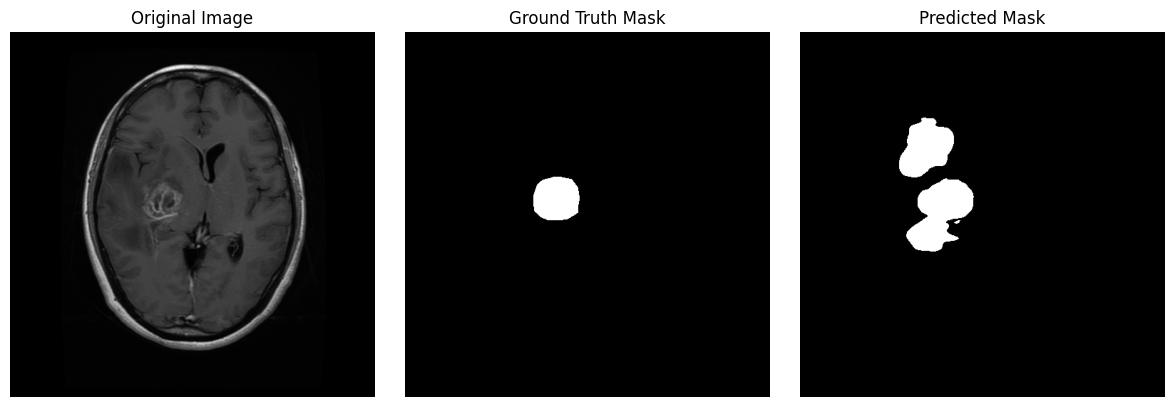

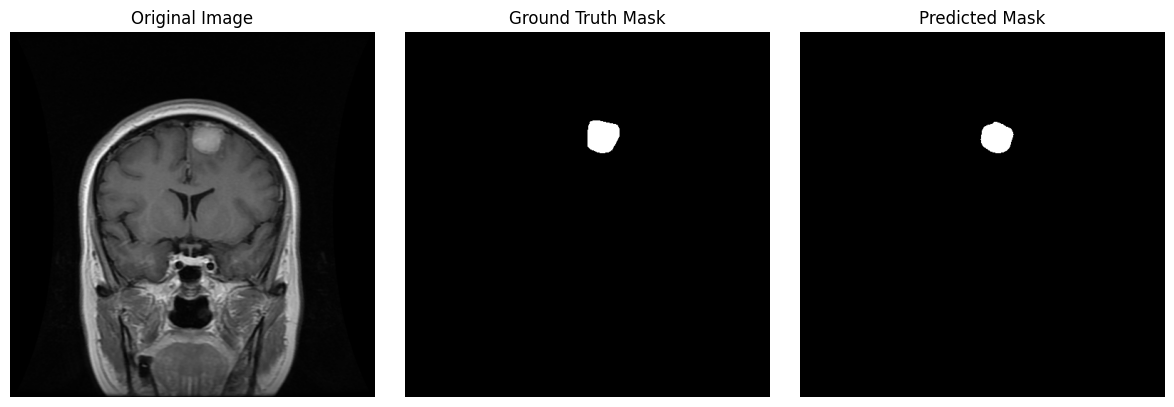

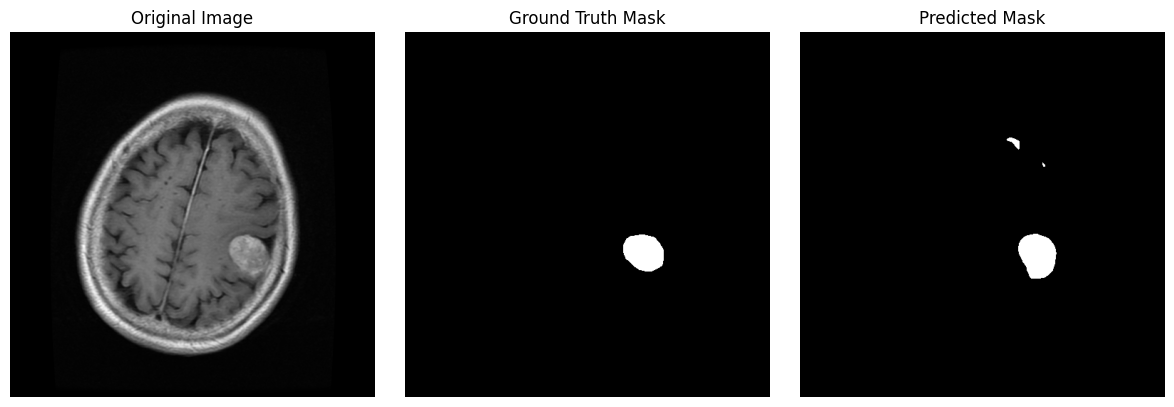

Accuracy: 99.10%
Average Dice Score: 73.84%


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def check_accuracy_and_visualize(loader, model, device="cuda", num_samples=10):
    num_correct = 0
    num_pixels = 0
    cumulative_dice_score = 0
    model.eval()

    samples_visualized = 0

    with torch.no_grad():
        for img, mask in loader:
            img = img.to(device)
            mask = mask.to(device)  

            preds = model(img)
            probs = torch.sigmoid(preds)
            preds = (probs > 0.5).float()  

            num_correct += (preds == mask).sum().item()
            num_pixels += torch.numel(preds)

            intersection = (preds * mask).sum().item()
            dice_score = (2 * intersection) / ((preds + mask).sum().item() + 1e-6)
            cumulative_dice_score += dice_score

            if samples_visualized < num_samples:
                batch_size = img.size(0)
                for i in range(batch_size):
                    if samples_visualized >= num_samples:
                        break
                    original_img = F.to_pil_image(img[i].cpu().squeeze(0))
                    ground_truth_mask = F.to_pil_image(mask[i].cpu().squeeze(0))
                    predicted_mask = F.to_pil_image(preds[i].cpu().squeeze(0))

                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 3, 1)
                    plt.imshow(original_img, cmap="gray")
                    plt.title("Original Image")
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.imshow(ground_truth_mask, cmap="gray")
                    plt.title("Ground Truth Mask")
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.imshow(predicted_mask, cmap="gray")
                    plt.title("Predicted Mask")
                    plt.axis("off")

                    plt.tight_layout()
                    plt.show()

                    samples_visualized += 1

    accuracy = num_correct / num_pixels * 100
    avg_dice_score = cumulative_dice_score / len(loader)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Average Dice Score: {avg_dice_score*100:.2f}%")

    model.train()

check_accuracy_and_visualize(test_loader, model, loss_fn, num_samples=20)